In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
import matrixprofile as mp

def mprofile(ts):
    profile = mp.compute(ts, windows=48)
    figures = mp.visualize(profile)
    ax = plt.gca()
    ax.set_title(f'Matrix profile, 1 day window')

In [3]:
data = pd.read_csv('data.csv').to_numpy()

In [4]:
data = (data - data.mean(axis=1).reshape(-1, 1)) / data.std(axis=1).reshape(-1, 1)

In [5]:
train_length = round(len(data) * 0.8)

In [6]:
train_data = torch.tensor(data[:train_length], dtype=torch.float32)
test_data = torch.tensor(data[train_length:], dtype=torch.float32)
all_data = torch.tensor(data, dtype=torch.float32)

In [7]:
train_loader = DataLoader(TensorDataset(train_data), batch_size=16, shuffle=True)
test_loader = DataLoader(TensorDataset(test_data), batch_size=16, shuffle=False)
all_loader = DataLoader(TensorDataset(all_data), batch_size=16, shuffle=True)

In [24]:
# Сверточный автокодировщик
class ConvAutoencoder(nn.Module):
    def __init__(self, bottleneck_size):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=3, stride=2),  # (B, 8, 743) o1
            nn.ReLU(),
            nn.Conv1d(8, 16, kernel_size=3, stride=2),  # (B, 16, 371) o1
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, stride=2),  # (B, 32, 185) o1
            nn.ReLU(),
            nn.Conv1d(32, 55, kernel_size=3, stride=2),  # (B, 64, 92) o1
            nn.Flatten(),
            nn.Linear(55 * 92, bottleneck_size)
            
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_size, 55 * 92),
            nn.Unflatten(1, (55, 92)),
            nn.ConvTranspose1d(55, 32, kernel_size=3, stride=2),  # (B, 32, 185)
            nn.ReLU(),
            nn.ConvTranspose1d(32, 16, kernel_size=3, stride=2),  # (B, 16, 371)
            nn.ReLU(),
            nn.ConvTranspose1d(16, 8, kernel_size=3, stride=2),  # (B, 8, 743)
            nn.ReLU(),
            nn.ConvTranspose1d(8, 1, kernel_size=3, stride=2, output_padding=1),  # (B, 1, 1488)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [26]:
model = ConvAutoencoder(bottleneck_size=48).to(device)

In [27]:
k = 0
for param in model.parameters():
    if param.requires_grad:
        k += torch.prod(torch.tensor(param.size()))
print(f'Model has {k} trainable parameters')

Model has 505484 trainable parameters


In [28]:
optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.MSELoss()

In [29]:
all_train_losses = []
train_losses = []
test_losses = []

In [32]:
epochs = 25

for epoch in range(epochs):
    avg_loss = 0
    model.train()
    for batch in train_loader:
        batch = batch[0].unsqueeze(1).to(device)
        preds = model(batch)
        loss = criterion(preds, batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        all_train_losses.append(loss.item())
        avg_loss += loss.item()
    avg_loss /= len(train_loader)
    print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}')
    train_losses.append(avg_loss)
    
    model.eval()
    avg_test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = batch[0].unsqueeze(1).to(device)
            preds = model(batch)
            loss = criterion(preds, batch)
            
            avg_test_loss += loss.item()
    avg_test_loss /= len(test_loader)
    test_losses.append(avg_test_loss)
    print(f'Test Loss: {avg_test_loss:.4f}')

Epoch 1, Loss: 0.2747
Test Loss: 0.3292
Epoch 2, Loss: 0.2744
Test Loss: 0.3297
Epoch 3, Loss: 0.2731
Test Loss: 0.3300
Epoch 4, Loss: 0.2717
Test Loss: 0.3302
Epoch 5, Loss: 0.2717
Test Loss: 0.3323
Epoch 6, Loss: 0.2711
Test Loss: 0.3323
Epoch 7, Loss: 0.2686
Test Loss: 0.3322
Epoch 8, Loss: 0.2684
Test Loss: 0.3323
Epoch 9, Loss: 0.2673
Test Loss: 0.3340
Epoch 10, Loss: 0.2665
Test Loss: 0.3350
Epoch 11, Loss: 0.2656
Test Loss: 0.3368
Epoch 12, Loss: 0.2656
Test Loss: 0.3343
Epoch 13, Loss: 0.2636
Test Loss: 0.3353
Epoch 14, Loss: 0.2625
Test Loss: 0.3360
Epoch 15, Loss: 0.2618
Test Loss: 0.3367
Epoch 16, Loss: 0.2618
Test Loss: 0.3374
Epoch 17, Loss: 0.2607
Test Loss: 0.3382
Epoch 18, Loss: 0.2607
Test Loss: 0.3392
Epoch 19, Loss: 0.2594
Test Loss: 0.3401
Epoch 20, Loss: 0.2575
Test Loss: 0.3399
Epoch 21, Loss: 0.2574
Test Loss: 0.3401
Epoch 22, Loss: 0.2562
Test Loss: 0.3413
Epoch 23, Loss: 0.2556
Test Loss: 0.3424
Epoch 24, Loss: 0.2549
Test Loss: 0.3425
Epoch 25, Loss: 0.2544
Te

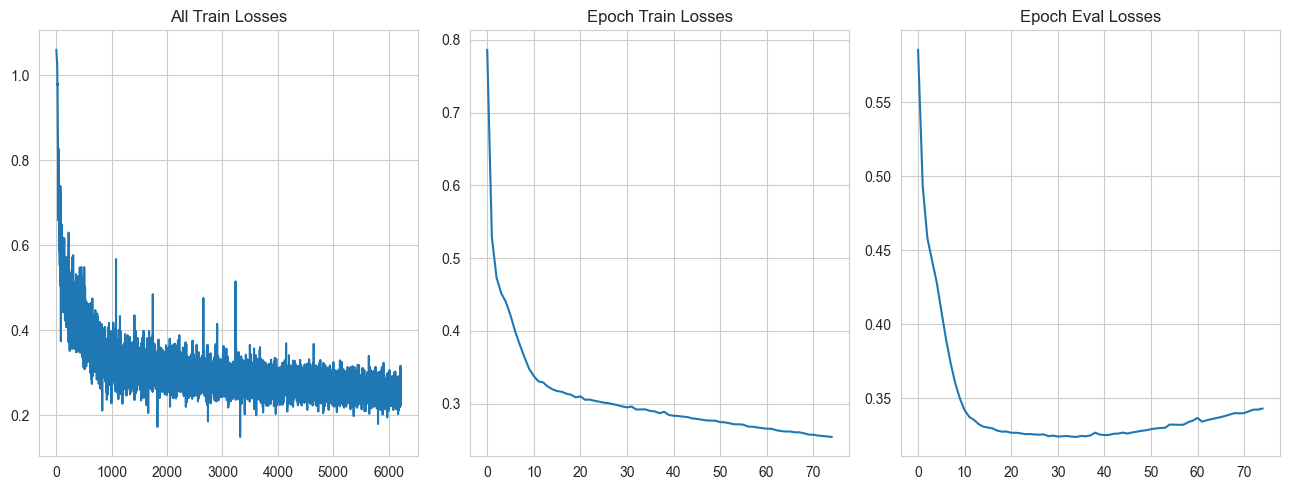

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(13, 5))
axes[0].plot(all_train_losses)
axes[0].set_title('All Train Losses')
axes[1].plot(train_losses)
axes[1].set_title('Epoch Train Losses')
axes[2].plot(test_losses)
axes[2].set_title('Epoch Eval Losses')
plt.tight_layout()
plt.show()

In [34]:
model = ConvAutoencoder(bottleneck_size=48).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

epochs = 25

for epoch in range(epochs):
    avg_loss = 0
    model.train()
    for batch in all_loader:
        batch = batch[0].unsqueeze(1).to(device)
        preds = model(batch)
        loss = criterion(preds, batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
    avg_loss /= len(train_loader)
    print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}')

Epoch 1, Loss: 0.9607
Epoch 2, Loss: 0.6400
Epoch 3, Loss: 0.5830
Epoch 4, Loss: 0.5586
Epoch 5, Loss: 0.5436
Epoch 6, Loss: 0.5264
Epoch 7, Loss: 0.5007
Epoch 8, Loss: 0.4691
Epoch 9, Loss: 0.4446
Epoch 10, Loss: 0.4290
Epoch 11, Loss: 0.4170
Epoch 12, Loss: 0.4096
Epoch 13, Loss: 0.4037
Epoch 14, Loss: 0.3996
Epoch 15, Loss: 0.3961
Epoch 16, Loss: 0.3937
Epoch 17, Loss: 0.3911
Epoch 18, Loss: 0.3886
Epoch 19, Loss: 0.3865
Epoch 20, Loss: 0.3844
Epoch 21, Loss: 0.3825
Epoch 22, Loss: 0.3807
Epoch 23, Loss: 0.3790
Epoch 24, Loss: 0.3771
Epoch 25, Loss: 0.3753


In [35]:
errors = []
encoded = []
reconstructed = []
with torch.no_grad():
    for sample in all_data:
        inputs = sample.view(1, 1, -1).to(device)
        res = model(inputs).cpu().detach().flatten()
        reconstruction_error = criterion(res, sample)
        errors.append(reconstruction_error.numpy())
        
        features = model.encoder(inputs).view(-1)
        encoded.append(features.cpu().detach().numpy())
        
        reconstructed.append(res.view(-1).cpu().detach().numpy())

errors = np.array(errors)
encoded = np.array(encoded)
reconstructed = np.array(reconstructed)

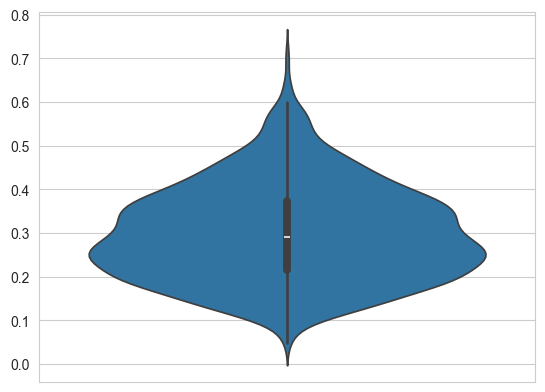

In [36]:
sns.violinplot(errors)
plt.show()

In [37]:
np.quantile(errors, 0.99)

0.578975360393524

In [38]:
np.column_stack((np.argsort(-errors), -np.sort(-errors)))

array([[1.22500000e+03, 7.16464400e-01],
       [2.80000000e+01, 6.93784714e-01],
       [9.08000000e+02, 6.93668306e-01],
       ...,
       [1.10200000e+03, 6.00750893e-02],
       [1.09000000e+02, 5.95143363e-02],
       [2.23000000e+02, 4.73272465e-02]])

In [ ]:
# 1225.0,0.716464
# 28.0,0.693785
# 908.0,0.693668
# 554.0,0.638555
# 1034.0,0.636524
# 142.0,0.631871
# 1578.0,0.630949
# 1178.0,0.625601
# 1146.0,0.618397
# 948.0,0.599472

In [39]:
def plot_sample(sample):
    _, ax = plt.subplots(figsize=(20, 5))
    ax.plot(data[sample], label='True Row')
    pred_row = reconstructed[sample]
    ax.plot(pred_row, label='Predicted Row')
    mse = np.linalg.norm(data[sample] - pred_row) ** 2 / len(data[sample])
    ax.set_title(f'Model Prediction VS True Row, MSE: {mse.round(2)}, Sample: {sample}')
    plt.legend()
    plt.show()

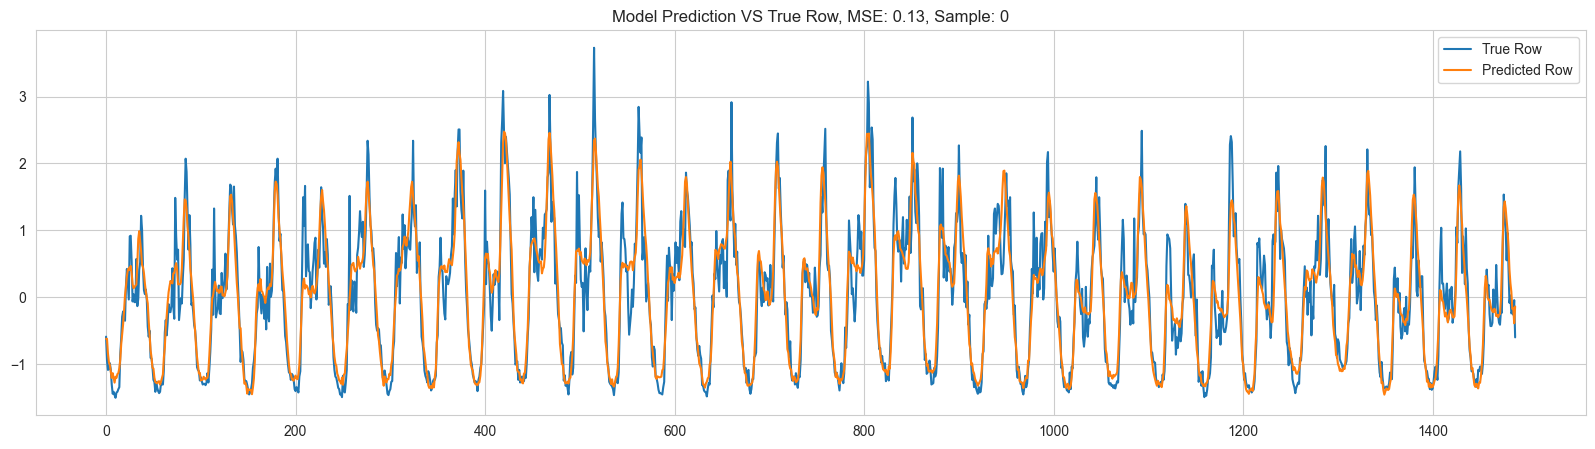

In [40]:
plot_sample(0)

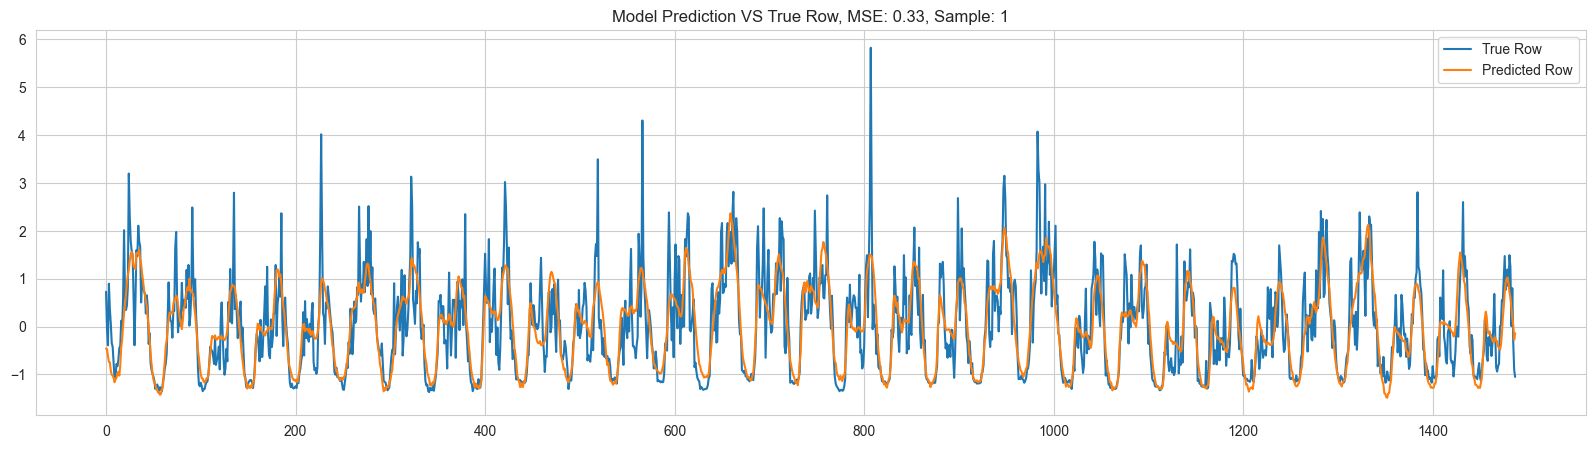

In [41]:
plot_sample(1)

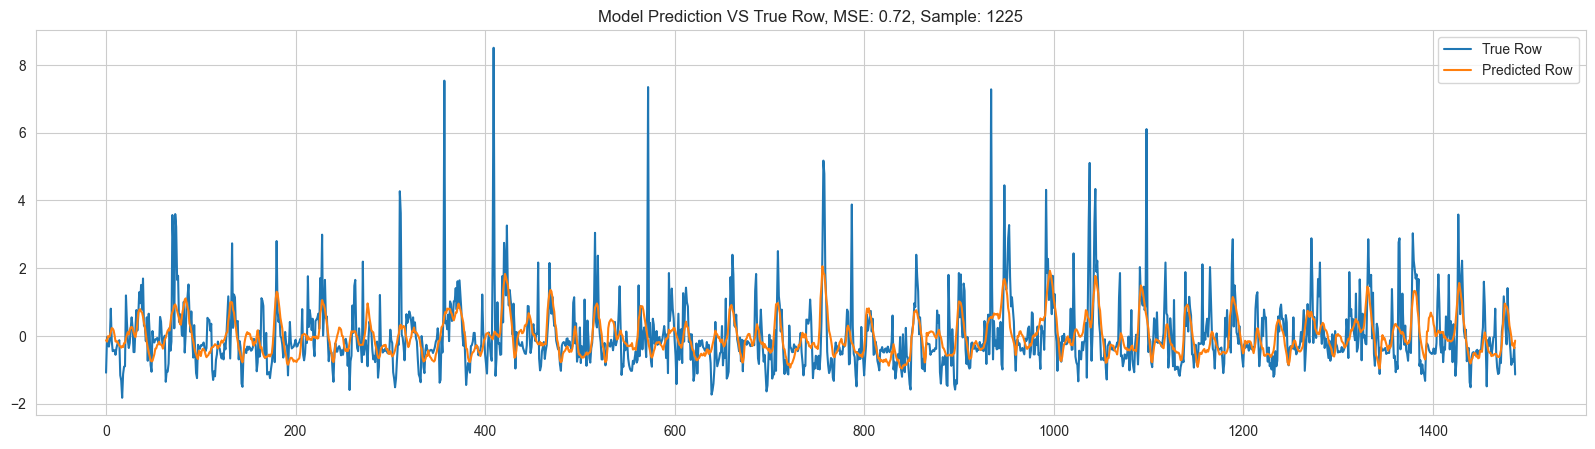

In [42]:
plot_sample(1225)

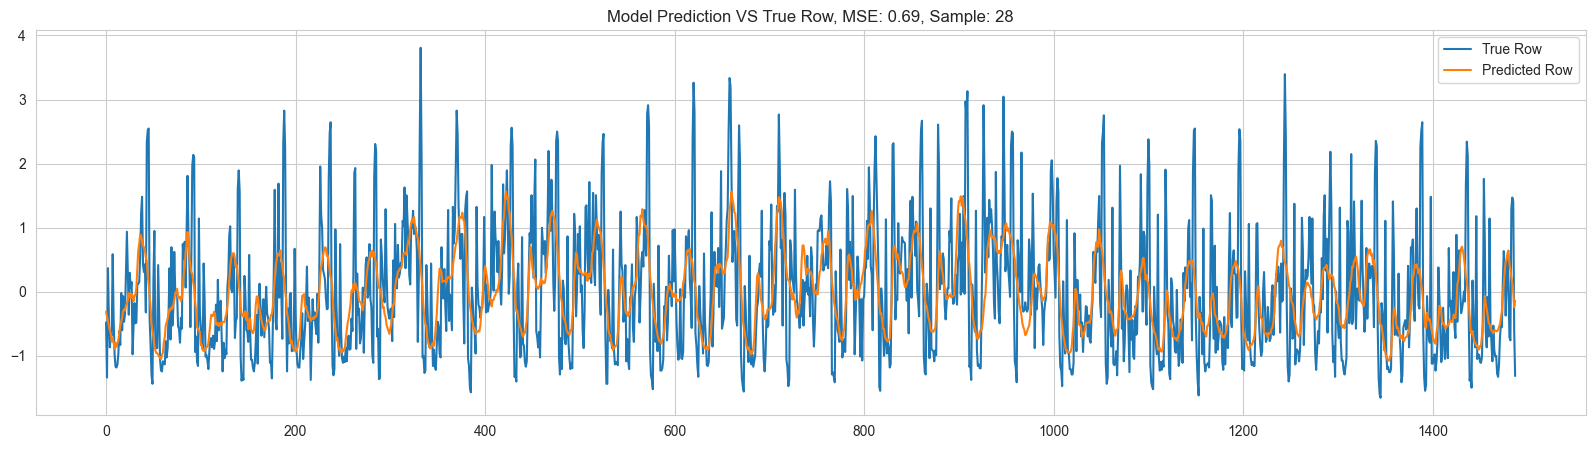

In [43]:
plot_sample(28)

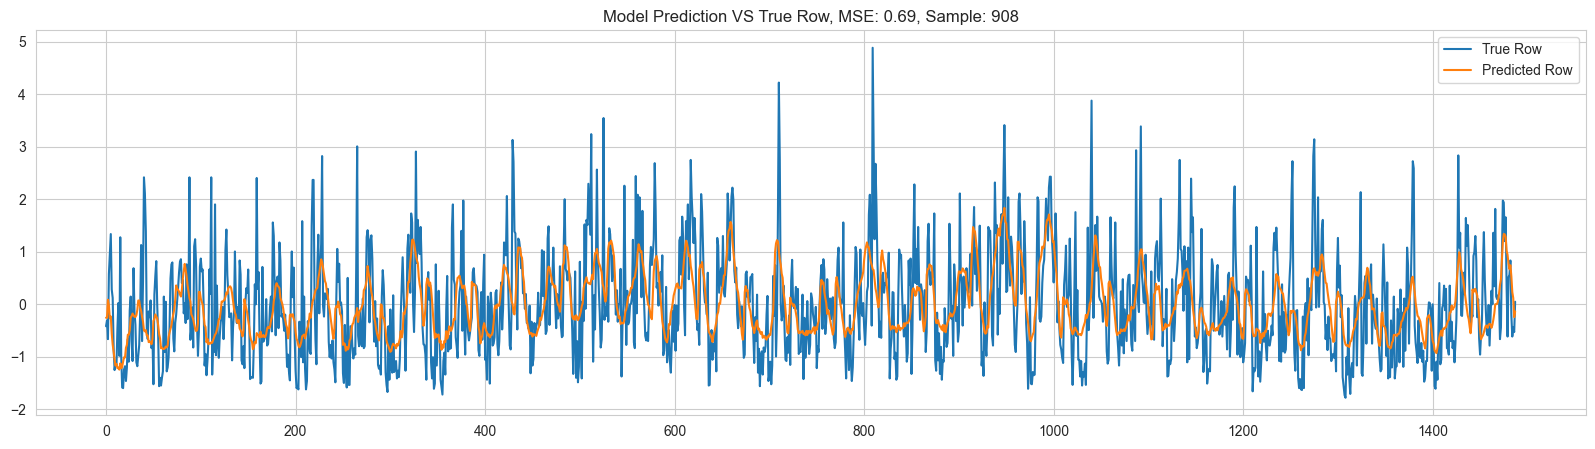

In [44]:
plot_sample(908)

In [38]:
# torch.save(model.state_dict(), 'models/convautoencoder_rec.pt')

In [45]:
encoded_norm = (encoded - encoded.mean(axis=0)) / encoded.std(axis=0)

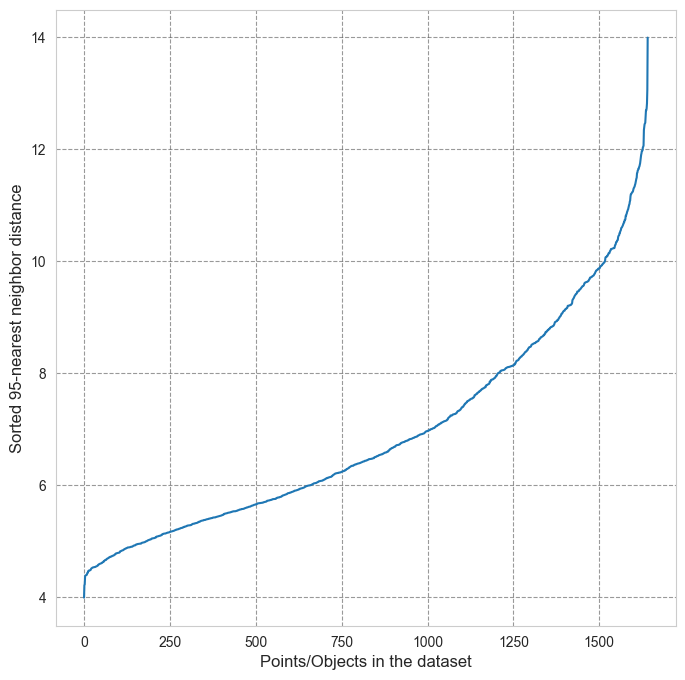

In [46]:
from sklearn.neighbors import NearestNeighbors


def get_kdist_plot(X=None, k=None, radius_nbrs=1.0):

    nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(X)

    # For each point, compute distances to its k-nearest neighbors
    distances, indices = nbrs.kneighbors(X) 
                                       
    distances = np.sort(distances, axis=0)
    distances = distances[:, k-1]

    # Plot the sorted K-nearest neighbor distance for each point in the dataset
    plt.figure(figsize=(8,8))
    plt.plot(distances)
    plt.xlabel('Points/Objects in the dataset', fontsize=12)
    plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
    plt.grid(True, linestyle="--", color='black', alpha=0.4)
    plt.show()
    plt.close()


k = 2 * encoded_norm.shape[-1] - 1 # k=2*{dim(dataset)} - 1
get_kdist_plot(X=encoded_norm, k=k)

In [62]:
from sklearn.cluster import DBSCAN

# Создаем объект DBSCAN
dbscan = DBSCAN(eps=10.7, min_samples=10)

# Проводим кластеризацию данных
clusters = dbscan.fit_predict(encoded_norm)

# Ищем объекты, отнесенные к кластеру -1 (это аномалии)
anomalies_indices = np.where(clusters == -1)[0]
anomalies_indices

array([  56,  146,  528,  704,  950, 1014, 1119, 1168, 1416, 1486],
      dtype=int64)

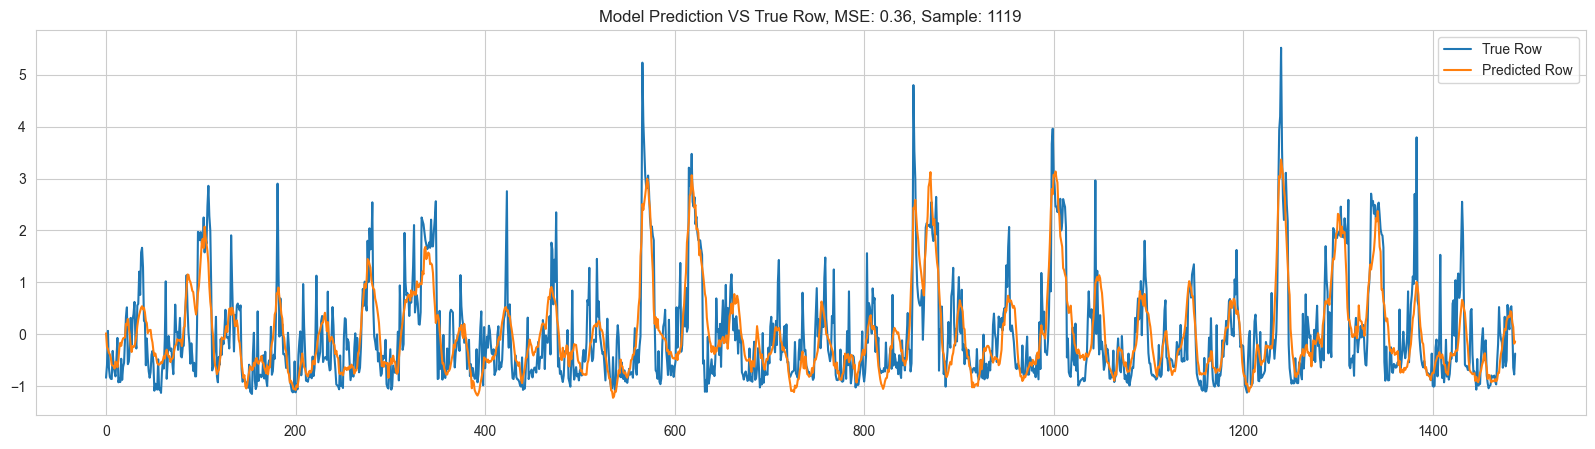

In [48]:
plot_sample(1119)

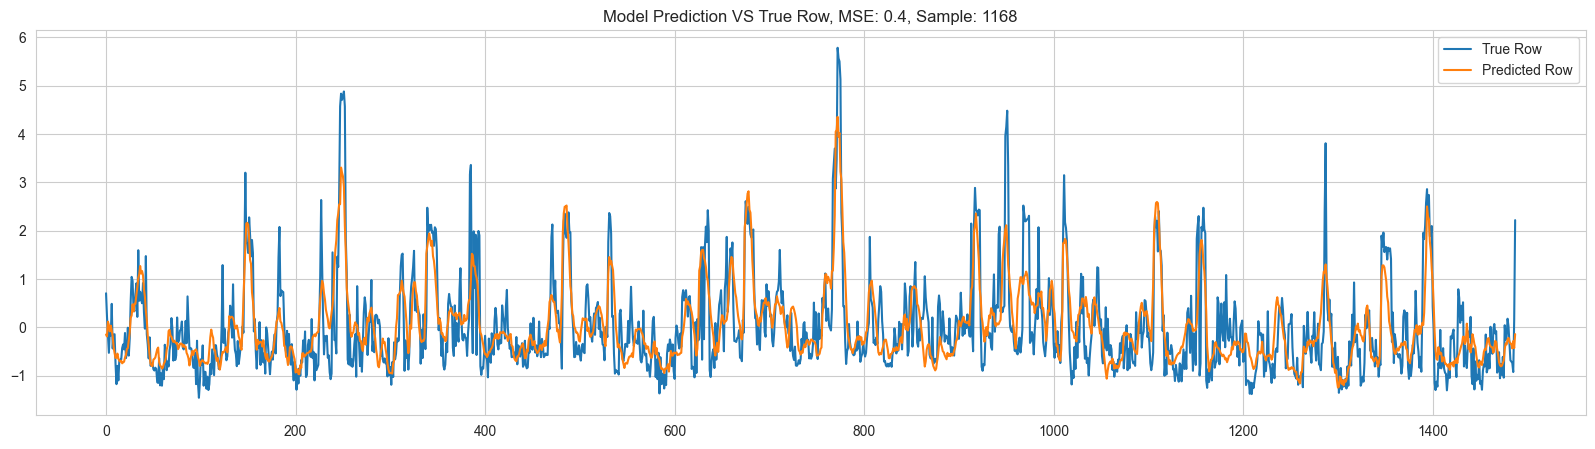

In [49]:
plot_sample(1168)

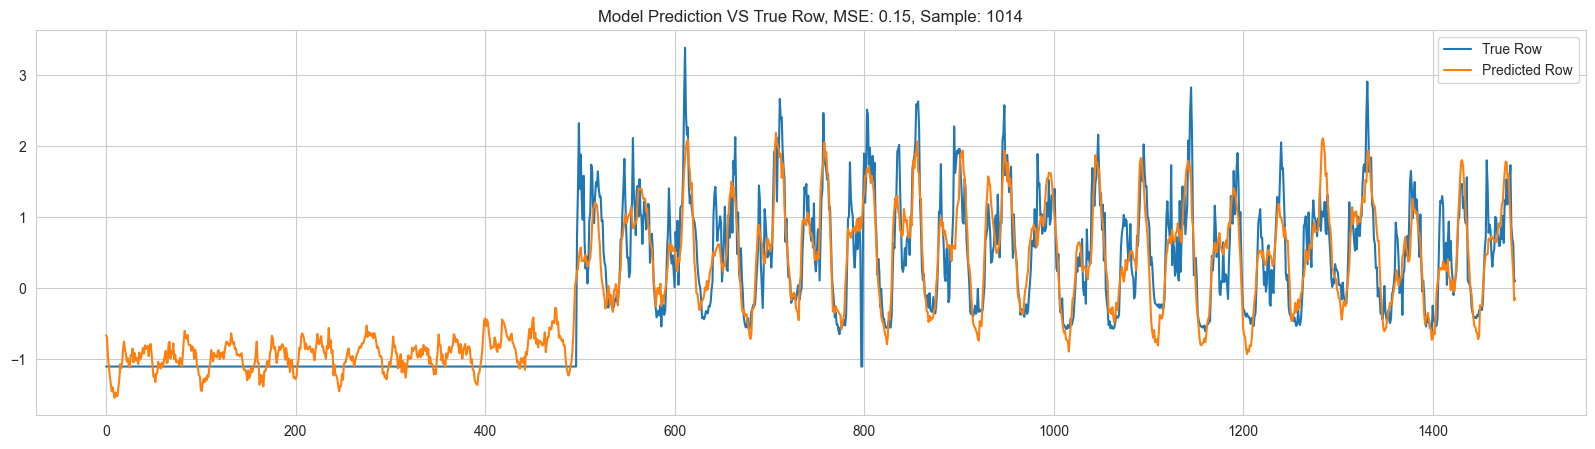

In [84]:
plot_sample(1486)

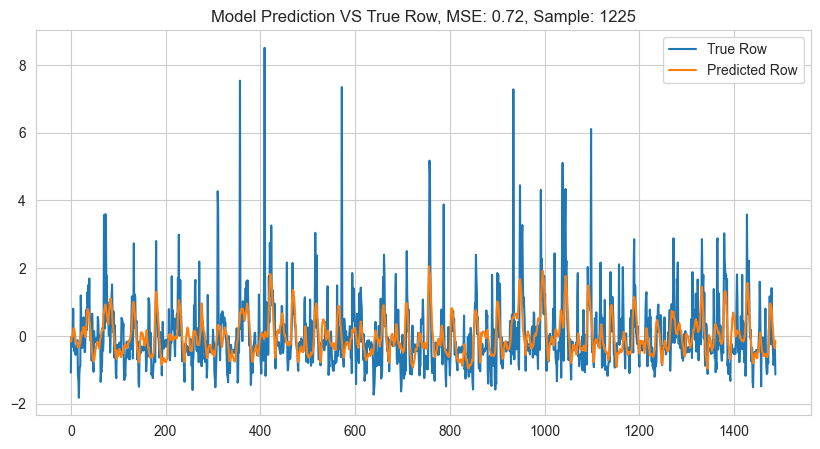

In [89]:
def plot_sample(sample):
    _, ax = plt.subplots(figsize=(10, 5))
    ax.plot(data[sample], label='True Row')
    pred_row = reconstructed[sample]
    ax.plot(pred_row, label='Predicted Row')
    mse = np.linalg.norm(data[sample] - pred_row) ** 2 / len(data[sample])
    ax.set_title(f'Model Prediction VS True Row, MSE: {mse.round(2)}, Sample: {sample}')
    plt.legend()
    plt.show()
plot_sample(1225)